In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler

In [96]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)

    optimizer.step()
    scheduler.step()  # Step the learning rate scheduler at the beginning of each epoch

    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    # if (test_loss > last_loss):
    #   break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [97]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Using GPU?: True
GPU Name: Tesla T4


In [98]:
def train(network,  data_generator, loss_function, optimize, logging = 200):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    input_data, target_output = input_data.to(device), target_output.to(device)
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%logging == 0): print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  networkModel.eval()
  with torch.no_grad():
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def drawPredictionsCIFAR10(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  #Plot some of the testing results
  networkModel.eval()
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)
  for i in range(skip_batches):
     _, (images,labels) = next(data_enumerator) #skip a few batches if needed
  _, (images,labels) = next(data_enumerator)
  images, labels = images.to(device), labels.to(device)
  with torch.no_grad():
    pred_catigories = networkModel(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) #adjust the plot size
    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      #plt.tight_layout()
      drawColor = 'black'
      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5     # unnormalize
      npimg = img.cpu().numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))  #, interpolation='none'
      plt.title(" O: {},\n L: {}".format(classes[pred_labels[cur].item()],classes[labels[cur]]), color=drawColor)
      plt.xticks([])
      plt.yticks([])

In [99]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image_w = 32
image_h = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #RGB mean and std. dev

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),                         #Random cropping
    transforms.RandomHorizontalFlip(),                            #Random flipping
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  #Random Rotation and translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 data
training_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset_augment = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [100]:
class Conv_block_batch_norm(nn.Module):
  def __init__(self, channels_in, channels_out):
      super().__init__()
      ks = 3
      self.conv = nn.Conv2d(channels_in, channels_out,kernel_size=ks, padding=1)
      self.bn = nn.BatchNorm2d(channels_out)

  def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
      x = self.conv(x)
      # x = F.relu(x)         # We could relu here, I'm not sure if it helps.
      x = self.bn(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = F.relu(x)
      return x

In [101]:
class Conv_residual_block(nn.Module):
  def __init__(self, channels_in_out, dropout_rate = 0.2): #in and out kernels must be the same size
    super().__init__()
    ks = 3
    self.conv1 = nn.Conv2d(channels_in_out, channels_in_out, kernel_size=ks, padding=1)
    self.conv2 = nn.Conv2d(channels_in_out, channels_in_out, kernel_size=ks, padding=1)

  def forward(self, x):
      resid = x
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = x + resid
      return x

In [104]:
class Conv_Res_Net_basic(nn.Module):
  def __init__(self, img_w, img_h, num_classes):
    super().__init__()
    num_kernels1 = 16
    num_kernels2 = 32
    num_kernels3 = 64
    #-- Block 1
    self.conv_block1 = Conv_block_batch_norm(3,num_kernels1)
    img_w = img_w//2 #Max pool shrinks size 2x
    img_h = img_h//2
    self.residual_block_1a = Conv_residual_block(num_kernels1)  #Kernel size does not change
    self.residual_block_1b = Conv_residual_block(num_kernels1)
    self.residual_block_1c = Conv_residual_block(num_kernels1)
    #-- Block 2
    self.conv_block2 = Conv_block_batch_norm(num_kernels1,num_kernels2)
    img_w = img_w//2 #Max pool shrinks size 2x
    img_h = img_h//2
    self.residual_block_2a = Conv_residual_block(num_kernels2)  #Kernel size does not change
    self.residual_block_2b = Conv_residual_block(num_kernels2)
    self.residual_block_2c = Conv_residual_block(num_kernels2)
    #-- Block 3
    self.conv_block3 = Conv_block_batch_norm(num_kernels2,num_kernels3)
    img_w = img_w//2 #Max pool shrinks size 2x
    img_h = img_h//2
    self.residual_block_3a = Conv_residual_block(num_kernels3)  #Kernel size does not change
    self.residual_block_3b = Conv_residual_block(num_kernels3)
    self.residual_block_3c = Conv_residual_block(num_kernels3)
    #-- Classifier
    self.flattened_dim = (img_w*img_h) * num_kernels3
    self.linear = nn.Linear(self.flattened_dim, num_classes)

  def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
    #-- Block 1 --
    x = self.conv_block1(x)
    x = self.residual_block_1a(x)   # You can have as many of these fixed width blocks as you want in a row
    x = self.residual_block_1b(x)
    x = self.residual_block_1c(x)
    #-- Block 2 --
    x = self.conv_block2(x)
    x = self.residual_block_2a(x)   # You can have as many of these fixed width blocks as you want in a row
    x = self.residual_block_2b(x)
    x = self.residual_block_2c(x)
    #-- Block 3 --
    x = self.conv_block3(x)
    x = self.residual_block_3a(x)   # You can have as many of these fixed width blocks as you want in a row
    x = self.residual_block_3b(x)
    x = self.residual_block_3c(x)
    #-- Linear Classifier --
    x = x.view(-1, self.flattened_dim)
    x = self.linear(x)

    return x

Num. Parameters: 325034
Data is Loaded
Batch [200/500], Train Loss: 1.4771
Batch [400/500], Train Loss: 1.3010
Epoch [1/5], Train Loss: 1.2437, Test Loss: 1.0347
Batch [200/500], Train Loss: 0.8565
Batch [400/500], Train Loss: 0.8387
Epoch [2/5], Train Loss: 0.8292, Test Loss: 0.8479
Batch [200/500], Train Loss: 0.7648
Batch [400/500], Train Loss: 0.7673
Epoch [3/5], Train Loss: 0.7669, Test Loss: 0.8283
Batch [200/500], Train Loss: 0.7649
Batch [400/500], Train Loss: 0.7627
Epoch [4/5], Train Loss: 0.7590, Test Loss: 0.8276
Batch [200/500], Train Loss: 0.7606
Batch [400/500], Train Loss: 0.7613
Epoch [5/5], Train Loss: 0.7581, Test Loss: 0.8278

Train Set: Accuracy: 36988/50000 (74.0%)

Test Set: Accuracy: 7157/10000 (71.6%)


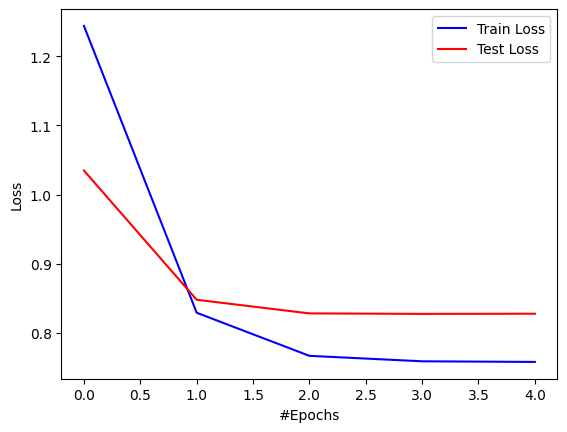

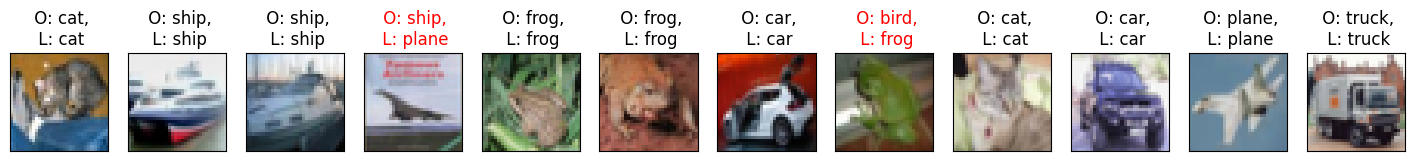

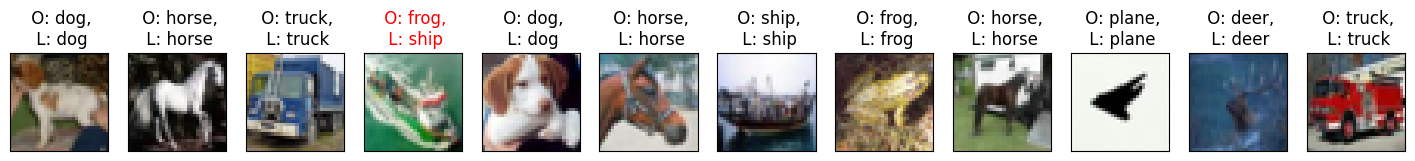

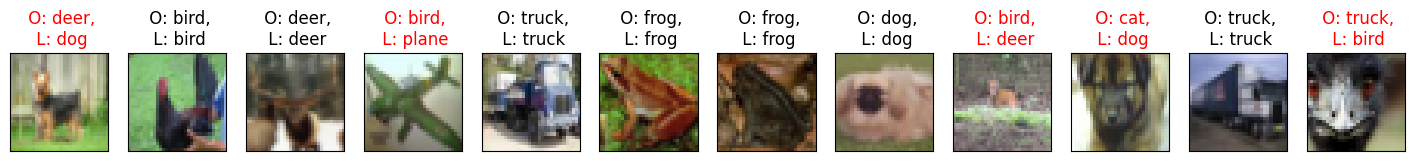

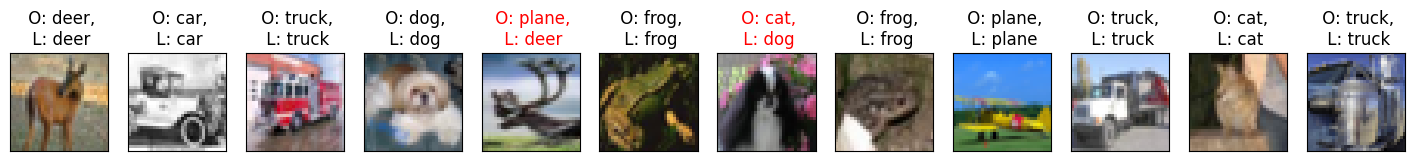

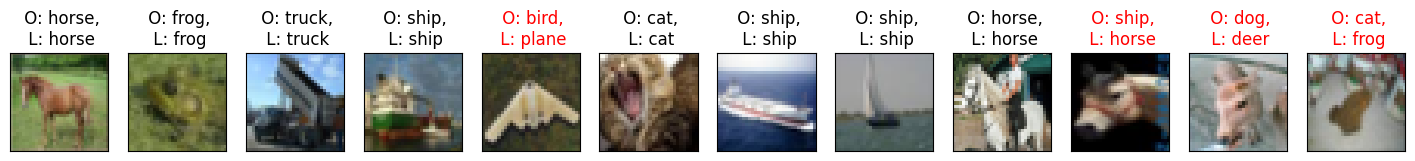

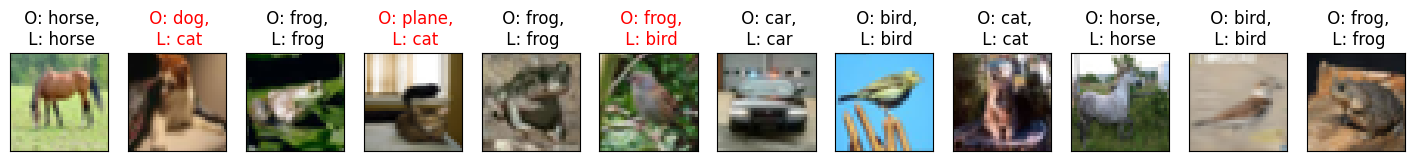

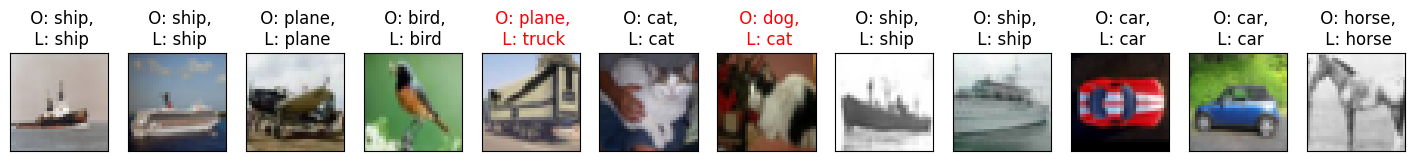

In [105]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.001
batch_size = 100

#Create model
network = Conv_Res_Net_basic(image_w, image_h, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)

In [108]:
class Conv_block_batch_norm(nn.Module):
  def __init__(self, channels_in, channels_out, kernel_size):
      super().__init__()
      self.conv = nn.Conv2d(channels_in, channels_out,kernel_size=kernel_size, padding=1)
      self.bn = nn.BatchNorm2d(channels_out)

  def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
      x = self.conv(x)
      # x = F.relu(x)         # We could relu here, I'm not sure if it helps.
      x = self.bn(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=3, stride = 2, padding = 1)
      return x

In [109]:
class Conv_residual_block(nn.Module):
    def __init__(self, low_kernel, high_kernel, stride=1, dropout_rate=0.2):
        super(Conv_residual_block, self).__init__()
        self.conv1 = nn.Conv2d(low_kernel, low_kernel, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(low_kernel)
        self.conv2 = nn.Conv2d(low_kernel, low_kernel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(low_kernel)
        self.conv3 = nn.Conv2d(low_kernel, high_kernel, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(high_kernel)
        self.shortcut = nn.Conv2d(low_kernel, high_kernel, kernel_size=1, stride=stride, padding=0)
        self.bn_shortcut = nn.BatchNorm2d(high_kernel)

    def forward(self, x):
        resid = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        resid = self.shortcut(resid)
        resid = self.bn_shortcut(resid)
        x = x + resid
        return x

In [110]:
class Conv_Res_Net_ResNet50(nn.Module):
    def __init__(self, img_w, img_h, num_classes):
        super(Conv_Res_Net_ResNet50, self).__init__()
        kernel_64 = 64
        kernel_128 = 128
        kernel_256 = 256
        kernel_512 = 512
        kernel_1024 = 1024
        kernel_2048 = 2048

        # Initial Convolution Layer
        self.conv1 = nn.Conv2d(3, kernel_64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(kernel_64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks
        self.residual_block_1a = Conv_residual_block(kernel_64, kernel_256, stride=1)
        self.residual_block_1b = Conv_residual_block(kernel_256, kernel_256, stride=1)
        self.residual_block_1c = Conv_residual_block(kernel_256, kernel_256, stride=1)

        self.residual_block_2a = Conv_residual_block(kernel_256, kernel_512, stride=2)
        self.residual_block_2b = Conv_residual_block(kernel_512, kernel_512, stride=1)
        self.residual_block_2c = Conv_residual_block(kernel_512, kernel_512, stride=1)
        self.residual_block_2d = Conv_residual_block(kernel_512, kernel_512, stride=1)

        self.residual_block_3a = Conv_residual_block(kernel_512, kernel_1024, stride=2)
        self.residual_block_3b = Conv_residual_block(kernel_1024, kernel_1024, stride=1)
        self.residual_block_3c = Conv_residual_block(kernel_1024, kernel_1024, stride=1)
        self.residual_block_3d = Conv_residual_block(kernel_1024, kernel_1024, stride=1)
        self.residual_block_3e = Conv_residual_block(kernel_1024, kernel_1024, stride=1)
        self.residual_block_3f = Conv_residual_block(kernel_1024, kernel_1024, stride=1)

        self.residual_block_4a = Conv_residual_block(kernel_1024, kernel_2048, stride=2)
        self.residual_block_4b = Conv_residual_block(kernel_2048, kernel_2048, stride=1)
        self.residual_block_4c = Conv_residual_block(kernel_2048, kernel_2048, stride=1)

        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(kernel_2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.residual_block_1a(x)
        x = self.residual_block_1b(x)
        x = self.residual_block_1c(x)

        x = self.residual_block_2a(x)
        x = self.residual_block_2b(x)
        x = self.residual_block_2c(x)
        x = self.residual_block_2d(x)

        x = self.residual_block_3a(x)
        x = self.residual_block_3b(x)
        x = self.residual_block_3c(x)
        x = self.residual_block_3d(x)
        x = self.residual_block_3e(x)
        x = self.residual_block_3f(x)

        x = self.residual_block_4a(x)
        x = self.residual_block_4b(x)
        x = self.residual_block_4c(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x


In [ ]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.01
weight_decay = 1e-4
batch_size = 128

#Create model
network = Conv_Res_Net_ResNet50(image_w, image_h, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)

Num. Parameters: 194128650
Data is Loaded


In [ ]:
class Conv_residual_block(nn.Module):
    def __init__(self, low_kernel, high_kernel, stride=1, dropout_rate=0.2):
        super(Conv_residual_block, self).__init__()
        self.conv1 = nn.Conv2d(low_kernel, low_kernel, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(low_kernel)
        self.conv2 = nn.Conv2d(low_kernel, low_kernel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(low_kernel)
        self.shortcut = nn.Conv2d(low_kernel, high_kernel, kernel_size=1, stride=stride, padding=0)
        self.bn_shortcut = nn.BatchNorm2d(high_kernel)

    def forward(self, x):
        resid = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        resid = self.shortcut(resid)
        resid = self.bn_shortcut(resid)
        x = x + resid
        return x

In [ ]:
class Conv_Res_Net_ResNet34(nn.Module):
    def __init__(self, img_w, img_h, num_classes):
        super(Conv_Res_Net_ResNet34, self).__init__()
        kernel_64 = 64
        kernel_128 = 128
        kernel_256 = 256
        kernel_512 = 512

        # Initial Convolution Layer
        self.conv1 = nn.Conv2d(3, kernel_64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(kernel_64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks
        self.residual_block_1a = Conv_residual_block(kernel_64, kernel_64, stride=1)
        self.residual_block_1b = Conv_residual_block(kernel_64, kernel_64, stride=1)
        self.residual_block_1c = Conv_residual_block(kernel_64, kernel_64, stride=1)

        self.residual_block_2a = Conv_residual_block(kernel_64, kernel_128, stride=2)
        self.residual_block_2b = Conv_residual_block(kernel_128, kernel_128, stride=1)
        self.residual_block_2c = Conv_residual_block(kernel_128, kernel_128, stride=1)
        self.residual_block_2d = Conv_residual_block(kernel_128, kernel_128, stride=1)

        self.residual_block_3a = Conv_residual_block(kernel_128, kernel_256, stride=2)
        self.residual_block_3b = Conv_residual_block(kernel_256, kernel_256, stride=1)
        self.residual_block_3c = Conv_residual_block(kernel_256, kernel_256, stride=1)
        self.residual_block_3d = Conv_residual_block(kernel_256, kernel_256, stride=1)
        self.residual_block_3e = Conv_residual_block(kernel_256, kernel_256, stride=1)
        self.residual_block_3f = Conv_residual_block(kernel_256, kernel_256, stride=1)

        self.residual_block_4a = Conv_residual_block(kernel_256, kernel_512, stride=2)
        self.residual_block_4b = Conv_residual_block(kernel_512, kernel_512, stride=1)
        self.residual_block_4c = Conv_residual_block(kernel_512, kernel_512, stride=1)

        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(kernel_512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.residual_block_1a(x)
        x = self.residual_block_1b(x)
        x = self.residual_block_1c(x)

        x = self.residual_block_2a(x)
        x = self.residual_block_2b(x)
        x = self.residual_block_2c(x)
        x = self.residual_block_2d(x)

        x = self.residual_block_3a(x)
        x = self.residual_block_3b(x)
        x = self.residual_block_3c(x)
        x = self.residual_block_3d(x)
        x = self.residual_block_3e(x)
        x = self.residual_block_3f(x)

        x = self.residual_block_4a(x)
        x = self.residual_block_4b(x)
        x = self.residual_block_4c(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

In [ ]:
#Training parameters
num_epochs = 5
print_interval = 1
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 100

#Create model
network = Conv_Res_Net_ResNet34(image_w, image_h, 10)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)